In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from scipy.stats import norm
import math
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
all_embeddings = pd.read_csv('data/trials_all_participants.csv')

In [4]:
all_embeddings['prediction'] = (all_embeddings.answer == 'melanoma').astype(int)
all_embeddings['hits'] = (all_embeddings.target == 1) & (all_embeddings.prediction == 1)
all_embeddings['misses'] = (all_embeddings.target == 1) & (all_embeddings.prediction == 0)
all_embeddings['correct_rejections'] = (all_embeddings.target == 0) & (all_embeddings.prediction == 0)
all_embeddings['false_alarms'] = (all_embeddings.target == 0) & (all_embeddings.prediction == 1)

In [140]:
participant_ids = [19769, 50342, 36844, 38012, 46875]#, 11568]

In [123]:
participant_ids = all_embeddings.groupby('participant_id').agg(count=('image_id', 'count')).query('count > 2000')\
                            .sort_values('count').tail(29).index

In [124]:
#set(participant_ids).difference(current)

In [125]:
#participant_ids = [38105,
# 39970,
# 44408,
# 45036,
# 46397]#, 11568]

In [141]:
#participant_ids = all_embeddings.participant_id.sample(14).values
embeddings = all_embeddings.query('participant_id in @participant_ids')

In [142]:
min_val = 0.01
max_val = 0.99
cluster_metrics = embeddings.groupby(['participant_id','cluster'])\
        .agg(
            cluster_acc=('score', 'mean'),
            cluster_hits=('hits', 'sum'),
            cluster_correct_rejections=('correct_rejections', 'sum'),
            cluster_misses=('misses', 'sum'),
            cluster_false_alarms=('false_alarms', 'sum'),
            cluster_positive=('target', 'sum'),
            cluster_negative=('target', lambda s: np.sum(s == 0))
        ).reset_index()

# Make sure no division by 0
cluster_metrics['cluster_positive'] = np.where(cluster_metrics.cluster_positive != 0, 
                                                 cluster_metrics.cluster_positive, np.nan)
cluster_metrics['cluster_negative'] = np.where(cluster_metrics.cluster_negative != 0, 
                                                 cluster_metrics.cluster_negative, np.nan)
# Compute sensitivity (TPR) and specificity (TNR)
cluster_metrics['cluster_sensitivity'] = (cluster_metrics.cluster_hits / cluster_metrics.cluster_positive).fillna(1)
cluster_metrics['cluster_specificity'] = (cluster_metrics.cluster_correct_rejections / cluster_metrics.cluster_negative).fillna(1)

# Compute the d prime for each subcluster
for (participant_id,i), group in embeddings.groupby(['participant_id','cluster']):
#    if group.target.nunique() == 2:
    if sum(group.target == 1) == 0:
        hit_rate = max_val#min_val
        fa_rate = sum(group.false_alarms) / sum(group.target == 0)
    elif sum(group.target == 0) == 0:
        hit_rate = sum(group.hits) / sum(group.target == 1)
        fa_rate = min_val
    else:
        hit_rate = sum(group.hits) / sum(group.target == 1)
        fa_rate = sum(group.false_alarms) / sum(group.target == 0)
        
    hit_rate = max(min(hit_rate, max_val), min_val)
    fa_rate = max(min(fa_rate, max_val), min_val)
    
    Zhit = norm.ppf(hit_rate)
    Zfa = norm.ppf(fa_rate)
    dprime = Zhit - Zfa
    criterion = - Zhit - Zfa
    mask = (cluster_metrics.participant_id == participant_id) & (cluster_metrics.cluster == i)
    if not math.isinf(dprime):
        cluster_metrics.loc[mask, 'cluster_dprime'] = dprime
    if not math.isinf(criterion):
        cluster_metrics.loc[mask, 'cluster_criterion'] = criterion
    else:
        print(dprime, criterion, hit_rate, fa_rate)#, sum(group.target == 1), sum(group.target == 0))

#cluster_metrics['cluster_dprime']
#cluster_metrics['cluster_criterion']

#metric_list = [col for col in participant_embeddings.columns if 'cluster_' in col]

In [143]:
participant_embeddings = embeddings.query('participant_id in @participant_ids').merge(cluster_metrics, on=['participant_id', 'cluster'])
#average_metrics = cluster_metrics.mean().to_frame().drop(['participant_id', 'cluster'])

In [144]:
average_metrics = cluster_metrics.drop('participant_id', axis=1).groupby('cluster').mean()
average_metrics.columns = [f"avg_{col}" for col in average_metrics.columns]
average_metrics = average_metrics.reset_index()
average_metrics

cluster  avg_cluster_acc  avg_cluster_hits  \
0         0         0.920158               0.0   
1         1         0.612955               0.0   
2         2         0.907930               0.0   
3         3         0.973304               0.0   
4         4         0.608411               0.0   
..      ...              ...               ...   
95       95         0.897645             356.2   
96       96         0.660332               0.0   
97       97         0.836763               0.0   
98       98         0.970499               0.0   
99       99         0.836274               0.0   

    avg_cluster_correct_rejections  avg_cluster_misses  \
0                             72.6                 0.0   
1                             52.8                 0.0   
2                             72.2                 0.0   
3                             61.8                 0.0   
4                             39.6                 0.0   
..                             ...                 ...   
95                             0.0                39.0   
96                            41.0                 0.0   
97                            41.6                 0.0   
98                            62.4                 0.0   
99                            57.2                 0.0   

    avg_cluster_false_alarms  avg_cluster_positive  avg_cluster_negative  \
0                        4.6                   NaN                  77.2   
1                       35.6                   NaN                  88.4   
2                        6.0                   NaN                  78.2   
3                        1.4                   NaN                  63.2   
4                       27.8                   NaN                  67.4   
..                       ...                   ...                   ...   
95                       0.0                 395.2                   NaN   
96                      20.4                   NaN                  61.4   
97                       7.8                   NaN                  49.4   
98                       1.6                   NaN                  64.0   
99                       8.4                   NaN                  65.6   

    avg_cluster_sensitivity  avg_cluster_specificity  avg_cluster_dprime  \
0                  1.000000                 0.920158            3.880023   
1                  1.000000                 0.612955            2.655928   
2                  1.000000                 0.907930            3.958204   
3                  1.000000                 0.973304            4.329048   
4                  1.000000                 0.608411            2.617340   
..                      ...                      ...                 ...   
95                 0.897645                 1.000000            3.645490   
96                 1.000000                 0.660332            2.804330   
97                 1.000000                 0.836763            3.371461   
98                 1.000000                 0.970499            4.295537   
99                 1.000000                 0.836274            3.452317   

    avg_cluster_criterion  
0               -0.772673  
1               -1.996768  
2               -0.694492  
3               -0.323647  
4               -2.035356  
..                    ...  
95               1.007205  
96              -1.848366  
97              -1.281235  
98              -0.357159  
99              -1.200378  

[100 rows x 12 columns]

In [145]:
average_metrics.describe()

cluster  avg_cluster_acc  avg_cluster_hits  \
count  100.000000       100.000000        100.000000   
mean    49.500000         0.786771         38.566000   
std     29.011492         0.174172        104.167461   
min      0.000000         0.381630          0.000000   
25%     24.750000         0.627825          0.000000   
50%     49.500000         0.868317          0.000000   
75%     74.250000         0.941187          0.000000   
max     99.000000         0.978991        587.800000   

       avg_cluster_correct_rejections  avg_cluster_misses  \
count                      100.000000          100.000000   
mean                        48.794000            7.710000   
std                         26.060543           20.128323   
min                          0.000000            0.000000   
25%                         33.750000            0.000000   
50%                         53.100000            0.000000   
75%                         67.950000            0.000000   
max                         97.000000          114.800000   

       avg_cluster_false_alarms  avg_cluster_positive  avg_cluster_negative  \
count                100.000000             24.000000             93.000000   
mean                  13.042000            192.816667             66.507348   
std                   13.076351            180.144830             21.679394   
min                    0.000000              1.400000              1.250000   
25%                    2.750000             12.050000             58.000000   
50%                    6.200000            191.000000             68.400000   
75%                   24.250000            328.850000             79.600000   
max                   49.600000            614.800000            125.600000   

       avg_cluster_sensitivity  avg_cluster_specificity  avg_cluster_dprime  \
count               100.000000               100.000000          100.000000   
mean                  0.924808                 0.771800            2.979707   
std                   0.168568                 0.207770            1.393732   
min                   0.290043                 0.200000           -0.333287   
25%                   1.000000                 0.611819            2.559789   
50%                   1.000000                 0.875778            3.482977   
75%                   1.000000                 0.947840            4.089900   
max                   1.000000                 1.000000            4.414543   

       avg_cluster_criterion  
count             100.000000  
mean               -0.854638  
std                 0.968295  
min                -2.680460  
25%                -1.727261  
50%                -0.695795  
75%                -0.456426  
max                 1.782793

In [146]:
participant_embeddings = participant_embeddings.merge(average_metrics, on=['cluster'])

In [147]:
participant_embeddings

image_id  participant_id  score  contest_id current_labeling_state  \
0        811701           19769      0         964          gold_standard   
1        811701           19769      1        2316          gold_standard   
2        814815           19769      1        1126          gold_standard   
3        814815           19769      1        2316          gold_standard   
4        813377           19769      0        1286          gold_standard   
...         ...             ...    ...         ...                    ...   
54051    810301           50342      1        1651          gold_standard   
54052    810301           50342      1        2427          gold_standard   
54053    810012           50342      1        2424          gold_standard   
54054    810169           50342      1        2531          gold_standard   
54055    818971           50342      0        2531          gold_standard   

                  response_submitted_at               problem_appeared_at  \
0      2020-05-11 09:20:30.368000+00:00  2020-05-11 09:20:28.227000+00:00   
1      2020-12-10 05:32:21.996000+00:00  2020-12-10 05:32:21.164000+00:00   
2      2020-06-20 12:36:08.229000+00:00  2020-06-20 12:36:07.525000+00:00   
3      2020-12-10 05:29:50.379000+00:00  2020-12-10 05:29:49.101000+00:00   
4      2020-07-28 08:52:19.076000+00:00  2020-07-28 08:52:18.510999+00:00   
...                                 ...                               ...   
54051  2020-09-12 14:42:10.959000+00:00  2020-09-12 14:42:09.964999+00:00   
54052  2021-01-04 20:44:25.338000+00:00  2021-01-04 20:44:24.647000+00:00   
54053  2021-01-03 22:21:33.617000+00:00  2021-01-03 22:21:32.599000+00:00   
54054  2021-01-21 13:39:41.750999+00:00  2021-01-21 13:39:40.703000+00:00   
54055  2021-01-21 21:56:58.141000+00:00  2021-01-21 21:56:57.367000+00:00   

                  image                  image_created_at  label  ...  \
0      ISIC_0032589.jpg  2020-05-01 22:54:11.396343+00:00  nevus  ...   
1      ISIC_0032589.jpg  2020-05-01 22:54:11.396343+00:00  nevus  ...   
2      ISIC_0029465.jpg  2020-05-01 23:27:49.043074+00:00  nevus  ...   
3      ISIC_0029465.jpg  2020-05-01 23:27:49.043074+00:00  nevus  ...   
4      ISIC_0030920.jpg  2020-05-01 23:07:46.473974+00:00  nevus  ...   
...                 ...                               ...    ...  ...   
54051  ISIC_0033994.jpg  2020-05-01 22:46:14.656116+00:00  nevus  ...   
54052  ISIC_0033994.jpg  2020-05-01 22:46:14.656116+00:00  nevus  ...   
54053  ISIC_0034274.jpg  2020-05-01 22:44:49.347320+00:00  nevus  ...   
54054  ISIC_0034122.jpg  2020-05-01 22:45:32.873513+00:00  nevus  ...   
54055  ISIC_0025327.jpg  2020-05-02 00:26:46.176227+00:00  nevus  ...   

      avg_cluster_hits avg_cluster_correct_rejections  avg_cluster_misses  \
0                  0.0                           39.0                 0.0   
1                  0.0                           39.0                 0.0   
2                  0.0                           39.0                 0.0   
3                  0.0                           39.0                 0.0   
4                  0.0                           39.0                 0.0   
...                ...                            ...                 ...   
54051              0.0                           33.8                 0.0   
54052              0.0                           33.8                 0.0   
54053              0.0                           33.8                 0.0   
54054              0.0                           33.8                 0.0   
54055              0.0                           33.8                 0.0   

       avg_cluster_false_alarms  avg_cluster_positive  avg_cluster_negative  \
0                          20.0                   NaN                  59.0   
1                          20.0                   NaN                  59.0   
2                          20.0                   NaN                  59.0   
3                          20.0        

In [148]:
#participant_embeddings['cluster_acc'] = (participant_embeddings.cluster_acc).round(1) 
#participant_embeddings['cluster_sensitivity'] = (participant_embeddings.cluster_sensitivity).round(1) 
#participant_embeddings['cluster_specificity'] = (participant_embeddings.cluster_specificity).round(1) 
#participant_embeddings['cluster_dprime'] = (participant_embeddings.cluster_dprime).round(1) 
#participant_embeddings['cluster_criterion'] = (participant_embeddings.cluster_criterion).round(1) 

In [149]:
participant_embeddings['cluster_acc'] = (participant_embeddings.cluster_acc - participant_embeddings.avg_cluster_acc).round(1) 
participant_embeddings['cluster_sensitivity'] = (participant_embeddings.cluster_sensitivity - participant_embeddings.avg_cluster_sensitivity).round(1) 
participant_embeddings['cluster_specificity'] = (participant_embeddings.cluster_specificity - participant_embeddings.avg_cluster_specificity).round(1) 
participant_embeddings['cluster_dprime'] = (participant_embeddings.cluster_dprime - participant_embeddings.avg_cluster_dprime).round(1) 
participant_embeddings['cluster_criterion'] = (participant_embeddings.cluster_criterion - participant_embeddings.avg_cluster_criterion).round(1) 

In [150]:
participant_embeddings.cluster_acc.describe()

count    54056.000000
mean         0.002053
std          0.099943
min         -0.400000
25%          0.000000
50%         -0.000000
75%          0.100000
max          0.300000
Name: cluster_acc, dtype: float64

In [151]:
metric_list = ['cluster_acc', 'cluster_sensitivity', 'cluster_specificity', 'cluster_dprime', 'cluster_criterion']
metric_names = ['accuracy', 'sensitivity', 'specificity', "d'", 'criterion']

#NAN_VALUE = -100000
assert participant_embeddings[metric_list].isna().sum().sum() == 0
#assert (participant_embeddings == NAN_VALUE).sum().sum() == 0
# Fill nan values with a specific value so we can use different markers when plotting
# o.w. nan values are not plot
#participant_embeddings_nan = participant_embeddings.fillna(NAN_VALUE)

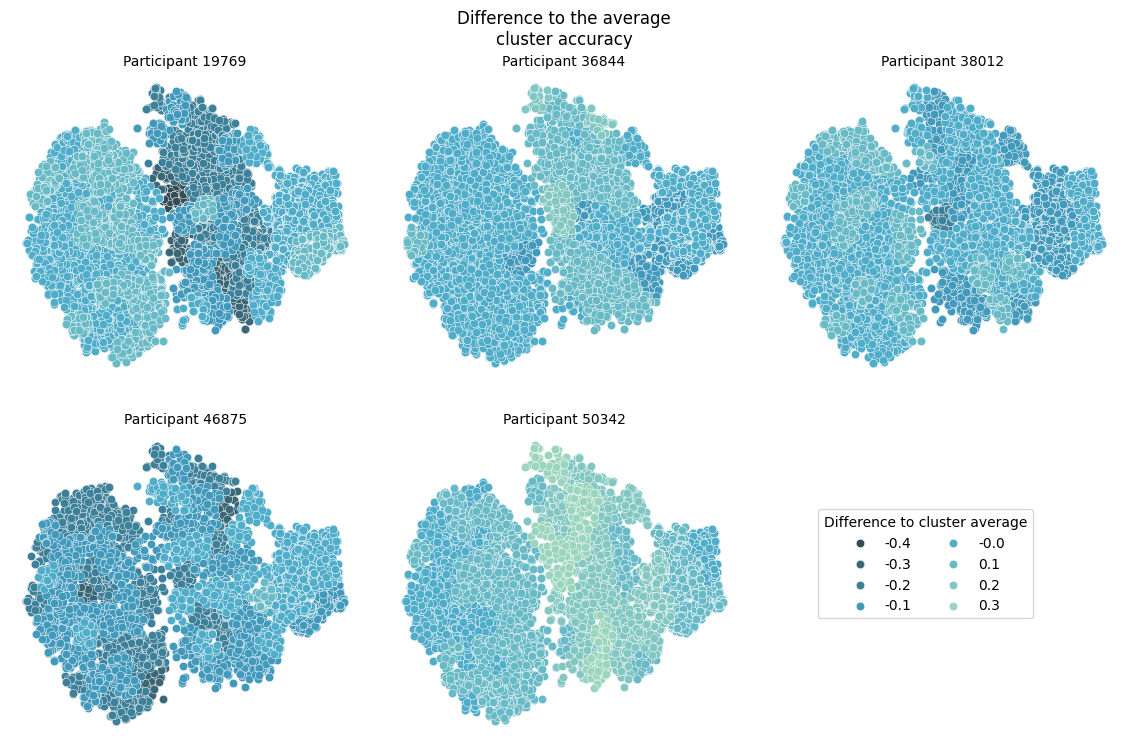

In [152]:
metric_col='cluster_acc'
metric_name=f"Difference to the average\ncluster accuracy"

g = sns.FacetGrid(participant_embeddings, col="participant_id", col_wrap=3,
                      hue=metric_col, palette='GnBu_r_d', height=4, aspect=1) #GnBu_d

def scatter_nan(x,y,metric_val, **kwargs):
    #nan_values = metric_val == NAN_VALUE
    sns.scatterplot(x=x, y=y, linewidth = 0.3, **kwargs)
    #sns.scatterplot(x=x[~nan_values], y=y[~nan_values], linewidth = 0.3, **kwargs)
    #fig = sns.scatterplot(x=x[nan_values], y=y[nan_values], color='lightblue', marker='+', label='NaN')

g.map(scatter_nan,'x', 'y', metric_col)
g.set_titles("Participant {col_name}")
g.despine(left=True, bottom=True)

# Trick to remove the -10 legend label used for NaNs
g.add_legend()
g.legend.remove()
handles = g.legend.legend_handles

while len(handles) > 12:
    handles = handles[::2]

#if (participant_embeddings_nan[metric_col] == NAN_VALUE).sum():
#    nan_markers = Line2D([], [], color='lightblue', marker='+', linestyle='None',
#                              markersize=8, label='Undefined')
#    handles[0] = nan_markers
#g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower center', 
#             bbox_to_anchor=(0.49, -0.04), ncols=len(handles))
g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower right', 
              bbox_to_anchor=(0.86, 0.21), ncols=2)

for ax in g.axes_dict.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
g.fig.subplots_adjust(top=0.9)
mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
g.fig.suptitle(metric_name, x=mid)
plt.show()

5it [00:32,  6.42s/it]


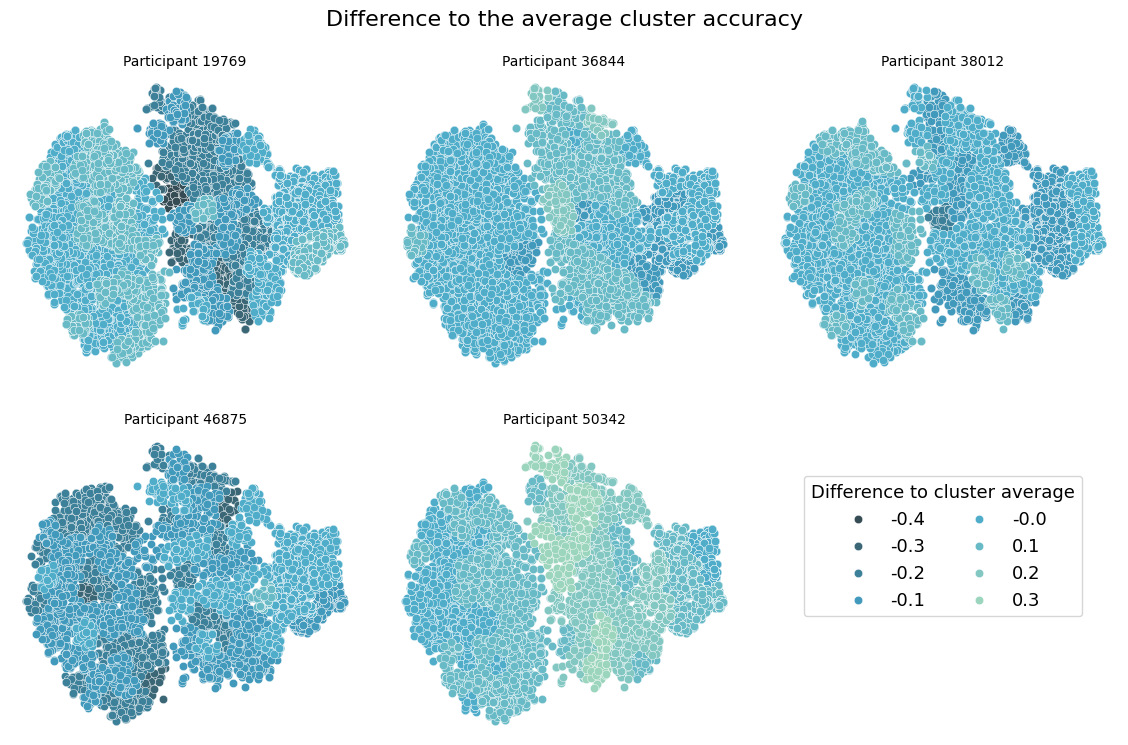

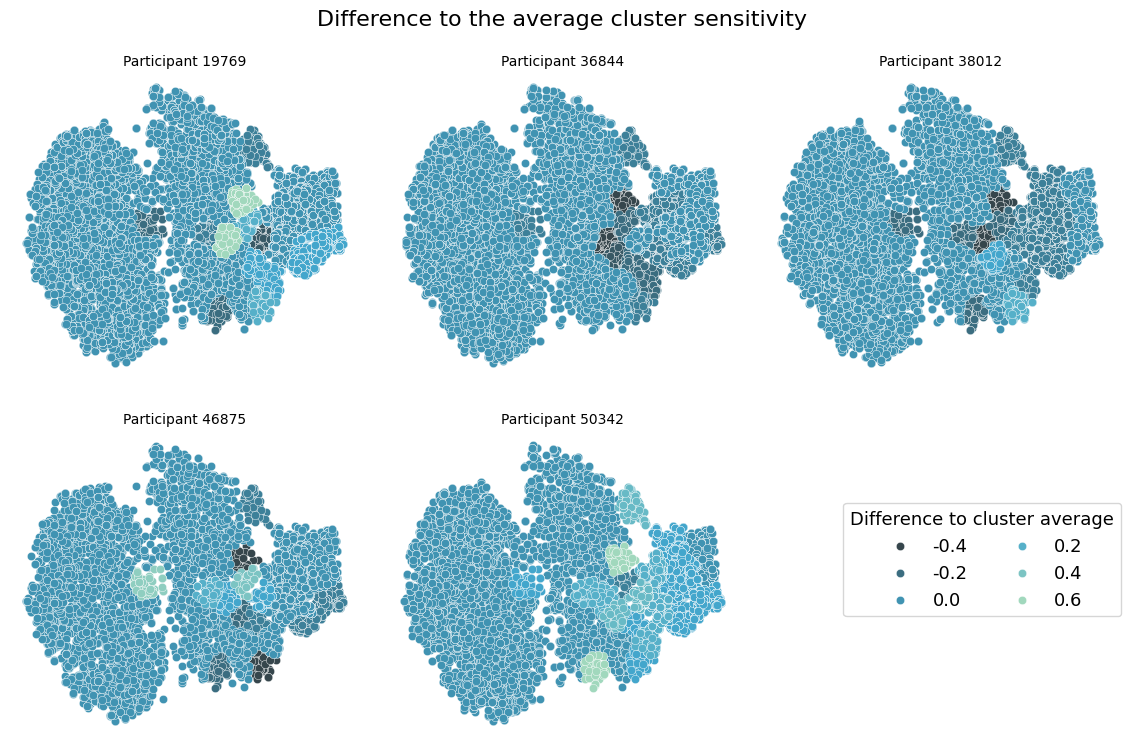

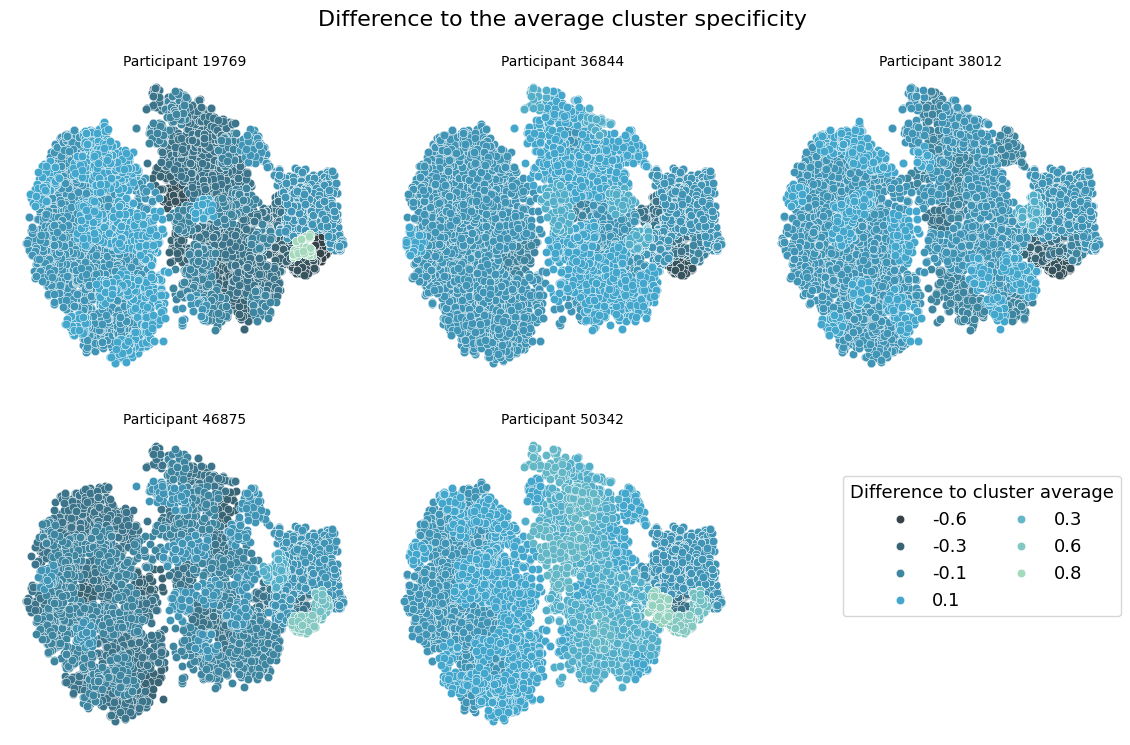

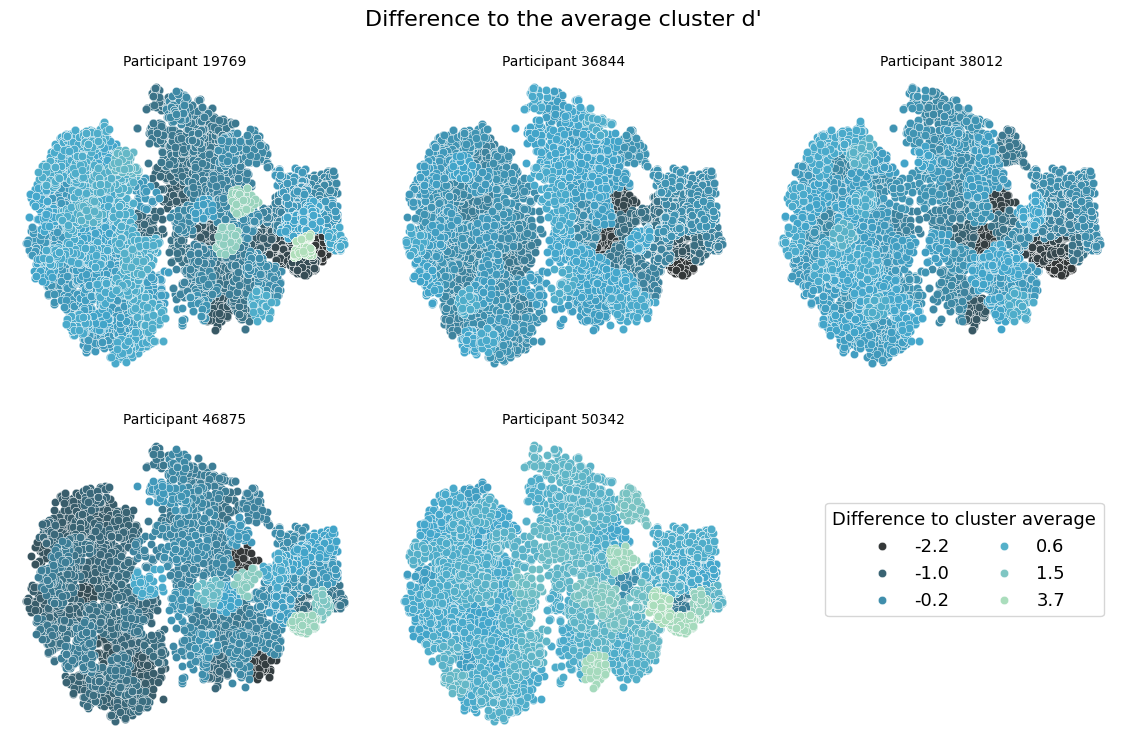

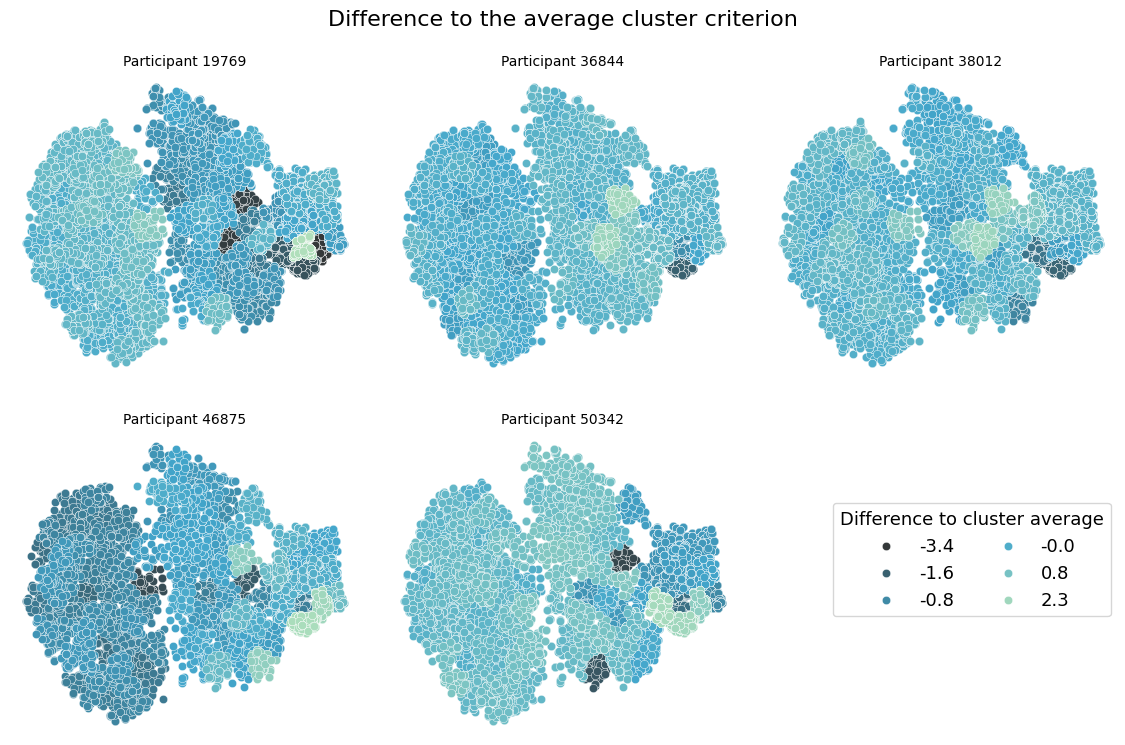

In [165]:
for metric_col, metric_name in tqdm(zip(metric_list, metric_names)):
    g = sns.FacetGrid(participant_embeddings, col="participant_id", col_wrap=3,
                      hue=metric_col, palette='GnBu_r_d', height=4, aspect=1) #GnBu_d

    def scatter_nan(x,y,metric_val, **kwargs):
        sns.scatterplot(x=x, y=y, linewidth = 0.3, **kwargs)
        #nan_values = metric_val == NAN_VALUE
        #sns.scatterplot(x=x[~nan_values], y=y[~nan_values], linewidth = 0.3, **kwargs)
        #fig = sns.scatterplot(x=x[nan_values], y=y[nan_values], color='lightblue', marker='+', label='NaN')

    g.map(scatter_nan,'x', 'y', metric_col)
    g.set_titles("Participant {col_name}")
    
    # Remove axes
    g.despine(left=True, bottom=True)
    for ax in g.axes_dict.values():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    # Create a legend with a limited number of elements
    g.add_legend()
    g.legend.remove()
    handles = g.legend.legend_handles
    # Reduce de number of legend elements if needed
    while len(handles) > 10:
        handles = handles[::2]
    #if (participant_embeddings_nan[metric_col] == NAN_VALUE).sum():
    #    nan_markers = Line2D([], [], color='lightblue', marker='+', linestyle='None',
    #                              markersize=8, label='Undefined')
    #    handles[0] = nan_markers
    #g.fig.legend(handles=handles, title=f"Difference to the cluster average", loc='lower center', 
    #         bbox_to_anchor=(0.48, -0.04), ncols=len(handles))
    g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower right', 
              bbox_to_anchor=(0.9, 0.21), ncols=2, 
            prop={'size': 13}, title_fontsize=13)

    g.fig.subplots_adjust(top=0.9)
    mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
    g.fig.suptitle(f"Difference to the average cluster {metric_name}", x=mid, fontsize=16)
    plt.savefig(metric_col+".png", dpi=300, bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

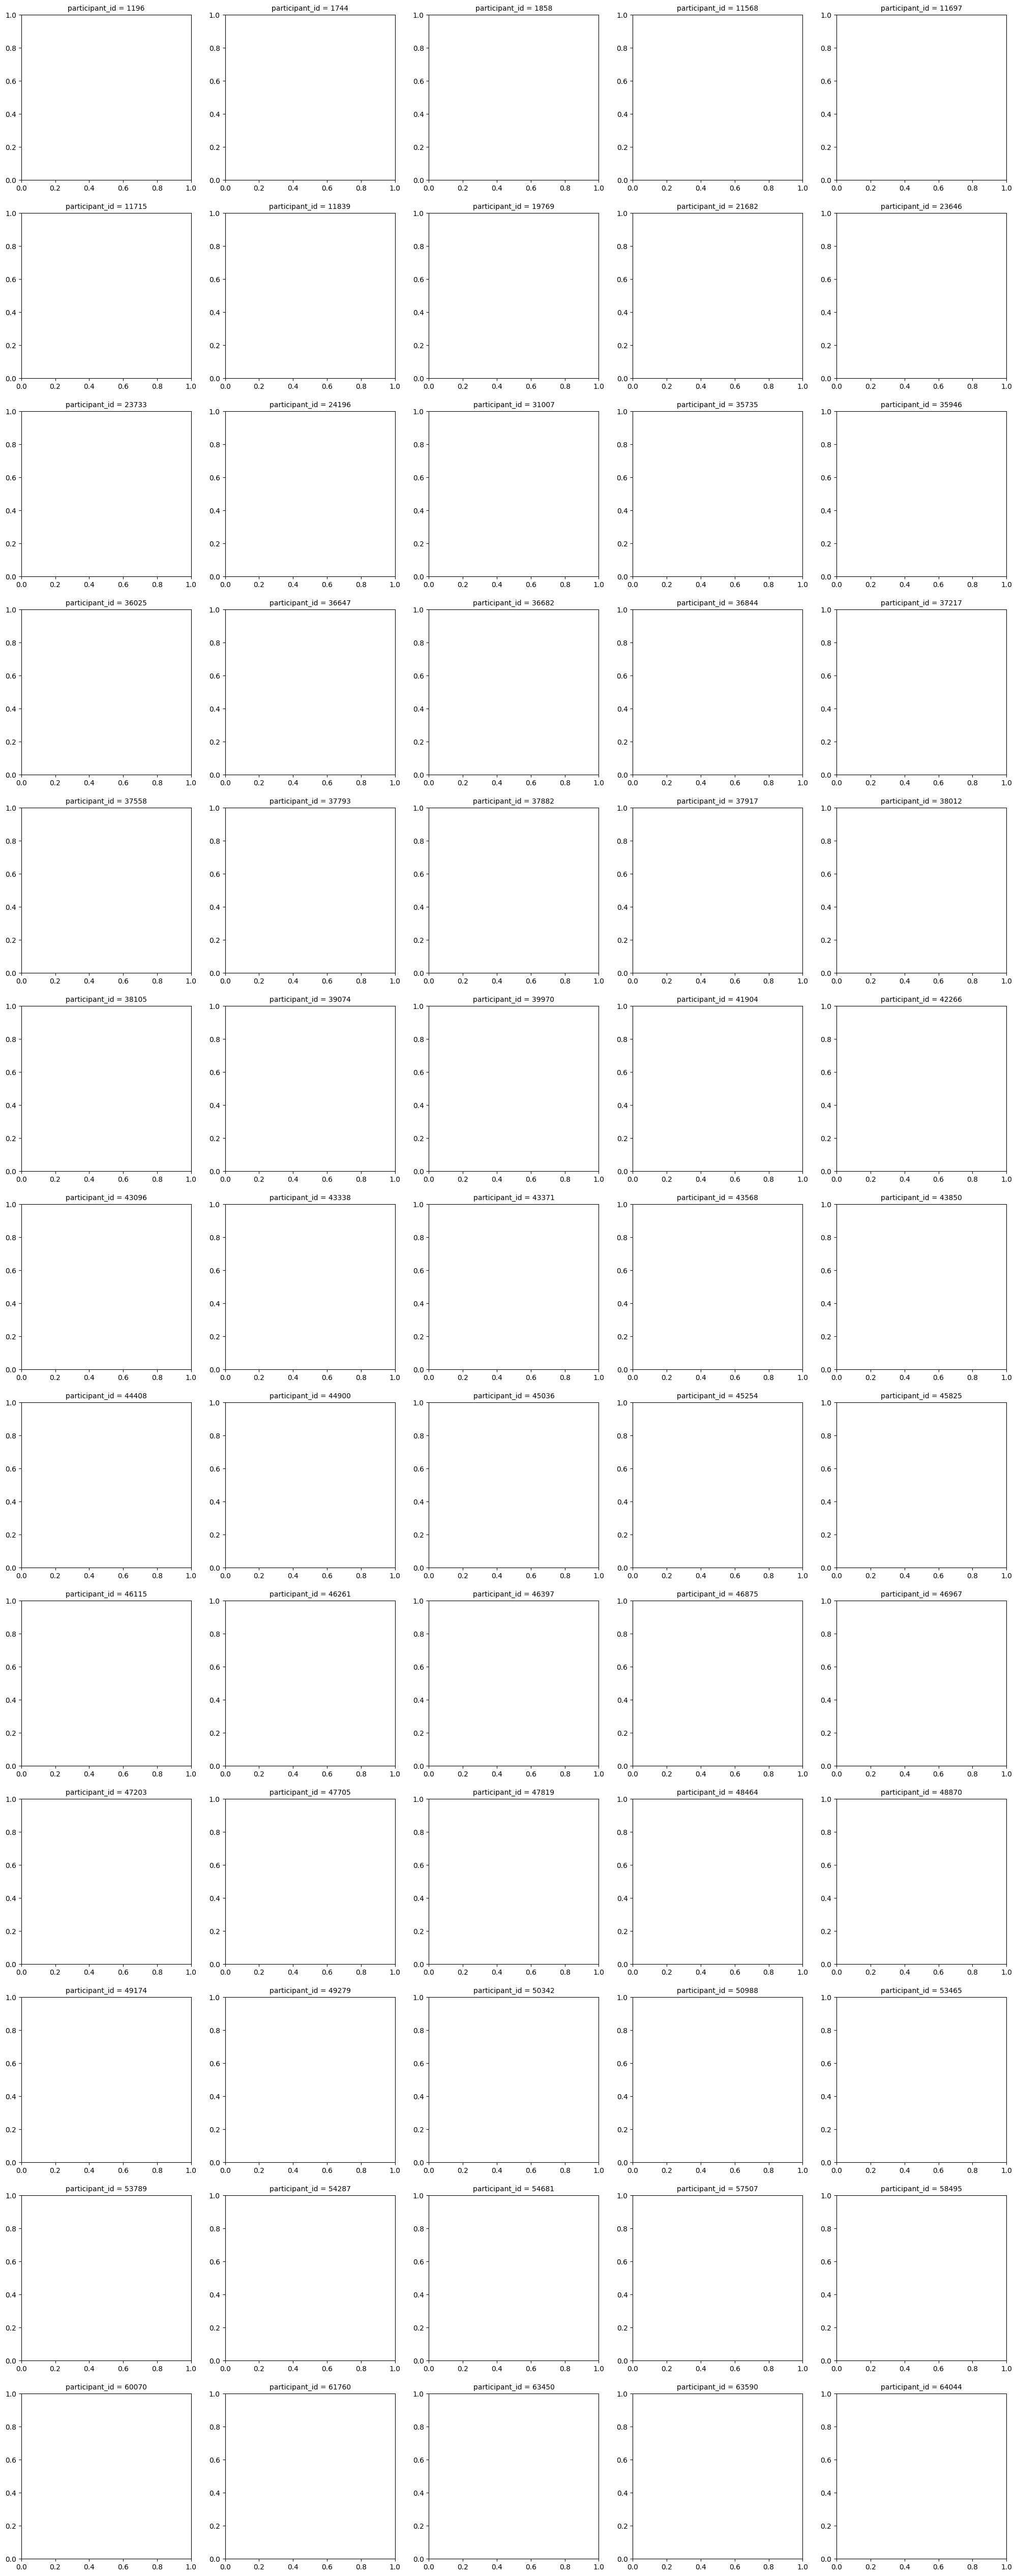

In [91]:
metric_col='cluster_acc'
metric_name=f"Difference to the average cluster accuracy of 30 participants"
fontsize=40

g = sns.FacetGrid(participant_embeddings, col="participant_id", col_wrap=5,
                      hue=metric_col, palette='GnBu_r_d', height=5, aspect=1) #GnBu_d

def scatter_nan(x,y,metric_val, **kwargs):
    #nan_values = metric_val == NAN_VALUE
    sns.scatterplot(x=x, y=y, linewidth=0.2,s=30, **kwargs)
    #sns.scatterplot(x=x[~nan_values], y=y[~nan_values], linewidth = 0.3, **kwargs)
    #fig = sns.scatterplot(x=x[nan_values], y=y[nan_values], color='lightblue', marker='+', label='NaN')

g.map(scatter_nan,'x', 'y', metric_col)
g.set_titles("", size=25)
g.despine(left=True, bottom=True)

# Trick to remove the -10 legend label used for NaNs
g.add_legend()
g.legend.remove()
handles = g.legend.legend_handles

while len(handles) > 12:
    handles = handles[::2]

#if (participant_embeddings_nan[metric_col] == NAN_VALUE).sum():
#    nan_markers = Line2D([], [], color='lightblue', marker='+', linestyle='None',
#                              markersize=8, label='Undefined')
#    handles[0] = nan_markers
#g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower center', 
#             bbox_to_anchor=(0.49, -0.04), ncols=len(handles))
g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower right', 
             prop={'size': 20}, title_fontsize=20, markerscale=3,
              bbox_to_anchor=(0.96, 0.05), ncols=2)

for ax in g.axes_dict.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
g.fig.subplots_adjust(top=0.9)
mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
#g.fig.suptitle(metric_name, x=mid, y=0.93, fontsize=35)
plt.savefig("facet.png", dpi=300, bbox_inches='tight')
plt.show()

### Average cluster metrics across all participants

In [92]:
average_metrics_xy = participant_embeddings[['x','y', 'cluster']].drop_duplicates().merge(average_metrics.round(0), on=['cluster'])
average_metrics_xy

x          y  cluster  avg_cluster_acc  avg_cluster_hits  \
0     32.794132 -33.325200       60              0.7               0.0   
1     37.630870 -40.923138       60              0.7               0.0   
2     39.387430 -33.680557       60              0.7               0.0   
3     36.356290 -35.272083       60              0.7               0.0   
4     39.465390 -45.788136       60              0.7               0.0   
...         ...        ...      ...              ...               ...   
7792  20.462431  50.209454       33              0.7               0.0   
7793  29.198936  45.374516       33              0.7               0.0   
7794  19.984762  50.799076       33              0.7               0.0   
7795  34.256325  47.769060       33              0.7               0.0   
7796  26.163675  46.988500       33              0.7               0.0   

      avg_cluster_correct_rejections  avg_cluster_misses  \
0                               23.1                 0.0   
1                               23.1                 0.0   
2                               23.1                 0.0   
3                               23.1                 0.0   
4                               23.1                 0.0   
...                              ...                 ...   
7792                            23.0                 0.0   
7793                            23.0                 0.0   
7794                            23.0                 0.0   
7795                            23.0                 0.0   
7796                            23.0                 0.0   

      avg_cluster_false_alarms  avg_cluster_positive  avg_cluster_negative  \
0                         11.6                   NaN                  34.7   
1                         11.6                   NaN                  34.7   
2                         11.6                   NaN                  34.7   
3                         11.6                   NaN                  34.7   
4                         11.6                   NaN                  34.7   
...                        ...                   ...                   ...   
7792                       8.5                   NaN                  31.5   
7793                       8.5                   NaN                  31.5   
7794                       8.5                   NaN                  31.5   
7795                       8.5                   NaN                  31.5   
7796                       8.5                   NaN                  31.5   

      avg_cluster_sensitivity  avg_cluster_specificity  avg_cluster_dprime  \
0                         1.0                      0.7                 2.9   
1                         1.0                      0.7                 2.9   
2                         1.0                      0.7                 2.9   
3                         1.0                      0.7                 2.9   
4                         1.0                      0.7                 2.9   
...                       ...                      ...                 ...   
7792                      1.0                      0.7                 3.0   
7793                      1.0                      0.7                 3.0   
7794                      1.0                      0.7                 3.0   
7795                      1.0                      0.7                 3.0   
7796                      1.0                      0.7                 3.0   

      avg_cluster_criterion  
0                      -1.8  
1                      -1.8  
2                      -1.8  
3                      -1.8  
4                      -1.8  
...                     ...  
7792                   -1.6  
7793                   -1.6  
7794                   -1.6  
7795                   -1.6  
7796                   -1.6  

[7797 rows x 14 columns]

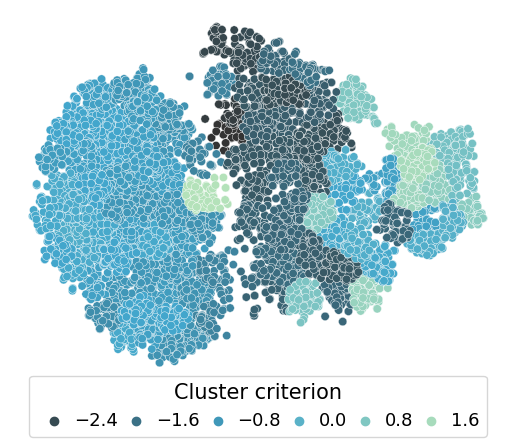

In [121]:
metric_col='cluster_criterion'
metric_name=f"criterion"

#for metric_col, metric_name in zip(metric_list, metric_names):
fig = sns.scatterplot(data=average_metrics_xy, x='x', y='y', hue="avg_"+metric_col, linewidth = 0.3, palette='GnBu_r_d')

handles = plt.legend().legend_handles
while len(handles) > 6:
    handles = handles[::2]
fig.legend(handles=handles, title="Cluster " + metric_name, loc='lower center', 
              bbox_to_anchor=(0.5, -0.18), ncols=len(handles),
               prop={'size': 13}, title_fontsize=15, markerscale=1, columnspacing=0, handletextpad=0.1)

sns.despine(left=True, bottom=True)
fig.get_xaxis().set_visible(False)
fig.get_yaxis().set_visible(False)
plt.savefig(metric_name+".png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
metric_col='cluster_acc'
metric_name=f"Difference to the average\ncluster accuracy"

g = sns.FacetGrid(participant_embeddings, col="participant_id", col_wrap=3,
                      hue=metric_col, palette='GnBu_r_d', height=4, aspect=1) #GnBu_d

def scatter_nan(x,y,metric_val, **kwargs):
    #nan_values = metric_val == NAN_VALUE
    sns.scatterplot(x=x, y=y, linewidth = 0.3, **kwargs)
    #sns.scatterplot(x=x[~nan_values], y=y[~nan_values], linewidth = 0.3, **kwargs)
    #fig = sns.scatterplot(x=x[nan_values], y=y[nan_values], color='lightblue', marker='+', label='NaN')

g.map(scatter_nan,'x', 'y', metric_col)
g.set_titles("Participant {col_name}")
g.despine(left=True, bottom=True)

# Trick to remove the -10 legend label used for NaNs
g.add_legend()
g.legend.remove()
handles = g.legend.legend_handles

while len(handles) > 12:
    handles = handles[::2]

#if (participant_embeddings_nan[metric_col] == NAN_VALUE).sum():
#    nan_markers = Line2D([], [], color='lightblue', marker='+', linestyle='None',
#                              markersize=8, label='Undefined')
#    handles[0] = nan_markers
#g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower center', 
#             bbox_to_anchor=(0.49, -0.04), ncols=len(handles))
g.fig.legend(handles=handles, title="Difference to cluster average", loc='lower right', 
              bbox_to_anchor=(0.86, 0.21), ncols=2)

for ax in g.axes_dict.values():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
g.fig.subplots_adjust(top=0.9)
mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
g.fig.suptitle(metric_name, x=mid)
plt.show()